# Chapter 19 - Deep Learning

### Import Libraries

In [1]:
import math 
import numpy as np
import pandas as pd
from typing import List

In [2]:
Vector = List[float]

def dot(v: Vector, w: Vector) -> float:
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"

    return sum(v_i * w_i for v_i, w_i in zip(v, w))

assert dot([1, 2, 3], [4, 5, 6]) == 32  # 1 * 4 + 2 * 5 + 3 * 6

In [3]:
Tensor = list

In [4]:
def shape(tensor: Tensor) -> List[int]:
    sizes: List[int] = []
    while isinstance(tensor, list):
        sizes.append(len(tensor))
        tensor = tensor[0]
    return size

In [5]:
# assert shape([1, 2, 3]) == 3
# assert shape([[1, 2], [3, 4], [5, 6]]) == [3, 2]

In [6]:
def is_1d(tensor: Tensor) -> bool:
    return not isinstance(tensor[0], list)

In [7]:
def tensor_sum(tensor: Tensor) -> float:
    if is_1d(tensor):
        return sum(tensor)
    else:
        return sum(tensor_sum(tensor_i)
                   for tensor_i in tensor)

In [8]:
from typing import Callable

In [9]:
def tensor_apply(f: Callable[[float], float], tensor: Tensor) -> Tensor:
    if is_1d(tensor):
        return [f(x) for x in tensor]
    else:
        return [tensor_apply(f, tensor_i) for tensor_i in tensor]

In [10]:
def zeros_like(tensor: Tensor) -> Tensor:
    return tensor_apply(lambda _: 0.0, tensor)

In [11]:
def tensor_combine(f: Callable[[float, float], float],
                   t1: Tensor,
                   t2: Tensor) -> Tensor:
    if is_1d(t1):
        return [f(x, y) for x, y in zip(t1, t2)]
    else:
        return [tensor_combine(f, t1_i, t2_i)
                for t1_i, t2_i in zip(t1, t2)]

In [12]:
import operator

### The Layer Abstraction

In [13]:
from typing import Iterable, Tuple

In [14]:
class Layer:
    
    def forward(self, input):
        raise NotImplementedError
        
    def backward(self, gradient):
        raise NotImplementedError
        
    def params(self) -> Iterable[Tensor]:
        return ()
    
    def grads(self) -> Iterable[Tensor]:
        return ()

In [15]:
def sigmoid(t: float) -> float:
    return 1 / (1 + math.exp(-t))

In [16]:
class Sigmoid(Layer):
    def forward(self, input: Tensor) -> Tensor:
        self.sigmoids = tensor_apply(sigmoid, input)
        return self.sigmoids
    
    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(lambda sig, grad: sig * (1 - sig) * grad,
                              self.sigmoids,
                              gradient)

### The Linear Layer

In [17]:
import random
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Various Normal cdfs')

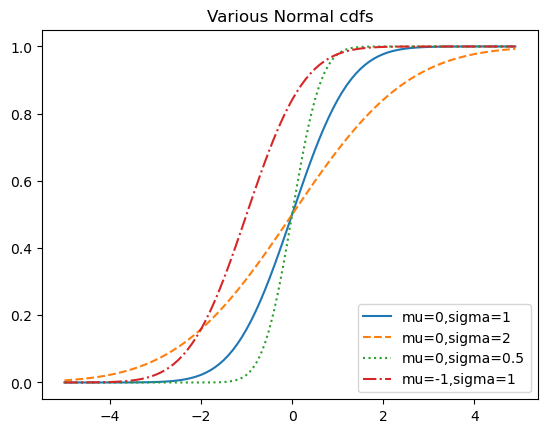

In [18]:
def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

xs = [x / 10.0 for x in range(-50, 50)]
plt.plot(xs,[normal_cdf(x,sigma=1) for x in xs],'-',label='mu=0,sigma=1')
plt.plot(xs,[normal_cdf(x,sigma=2) for x in xs],'--',label='mu=0,sigma=2')
plt.plot(xs,[normal_cdf(x,sigma=0.5) for x in xs],':',label='mu=0,sigma=0.5')
plt.plot(xs,[normal_cdf(x,mu=-1) for x in xs],'-.',label='mu=-1,sigma=1')
plt.legend(loc=4) # bottom right
plt.title("Various Normal cdfs")
# plt.show()

In [19]:
def random_uniform(*dims: int) -> Tensor:
    if len(dims) == 1:
        return [random.random() for _ in range(dims[0])]
    else:
        return [random_uniform(*dims[1:]) for _ in range(dims[0])]

In [20]:
def random_normal(*dims: int,
                  mean: float = 0.0,
                  variance: float = 1.0) -> Tensor:
    if len(dims) == 1:
        return [mean + variance * inverse_normal_cdf(random.random())
                for _ in range(dims[0])]
    else:
        return [random_normal(*dims[1:], mean=mean, variance=variance)
                for _ in range(dims[0])]

# assert shape(random_uniform(2, 3, 4)) == [2, 3, 4]
# assert shape(random_normal(5, 6, mean=10)) == [5, 6]

In [21]:
def random_tensor(*dims: int, init: str = 'normal') -> Tensor:
    if init == 'normal':
        return random_normal(*dims)
    elif init == 'uniform':
        return random_uniform(*dims)
    elif init == 'xavier':
        variance = len(dims) / sum(dims)
        return random_normal(*dims, variance=variance)
    else:
        raise ValueError(f"unknown init: {init}")

In [22]:
class Linear(Layer):
    def __init__(self, input_dim: int, output_dim: int, init: str = 'xavier') -> None:
        """
        A layer of output_dim neurons, each with input_dim weights
        (and a bias).
        """
        self.input_dim = input_dim
        self.output_dim = output_dim

        # self.w[o] is the weights for the o-th neuron
        self.w = random_tensor(output_dim, input_dim, init=init)

        # self.b[o] is the bias term for the o-th neuron
        self.b = random_tensor(output_dim, init=init)

    def forward(self, input: Tensor) -> Tensor:
        # Save the input to use in the backward pass.
        self.input = input

        # Return the vector of neuron outputs.
        return [dot(input, self.w[o]) + self.b[o]
                for o in range(self.output_dim)]

    def backward(self, gradient: Tensor) -> Tensor:
        # Each b[o] gets added to output[o], which means
        # the gradient of b is the same as the output gradient.
        self.b_grad = gradient

        # Each w[o][i] multiplies input[i] and gets added to output[o].
        # So its gradient is input[i] * gradient[o].
        self.w_grad = [[self.input[i] * gradient[o]
                        for i in range(self.input_dim)]
                       for o in range(self.output_dim)]

        # Each input[i] multiplies every w[o][i] and gets added to every
        # output[o]. So its gradient is the sum of w[o][i] * gradient[o]
        # across all the outputs.
        return [sum(self.w[o][i] * gradient[o] for o in range(self.output_dim))
                for i in range(self.input_dim)]

    def params(self) -> Iterable[Tensor]:
        return [self.w, self.b]

    def grads(self) -> Iterable[Tensor]:
        return [self.w_grad, self.b_grad]

### Neural Networks as a Sequence of Layers

In [23]:
class Sequential(Layer):
    """
    A layer consisting of a sequence of other layers.
    It's up to you to make sure that the output of each layer
    makes sense as the input to the next layer.
    """
    def __init__(self, layers: List[Layer]) -> None:
        self.layers = layers

    def forward(self, input):
        """Just forward the input through the layers in order."""
        for layer in self.layers:
            input = layer.forward(input)
        return input

    def backward(self, gradient):
        """Just backpropagate the gradient through the layers in reverse."""
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
        return gradient

    def params(self) -> Iterable[Tensor]:
        """Just return the params from each layer."""
        return (param for layer in self.layers for param in layer.params())

    def grads(self) -> Iterable[Tensor]:
        """Just return the grads from each layer."""
        return (grad for layer in self.layers for grad in layer.grads())

### Loss & Optimization

In [24]:
class Loss:
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        """How good are our predictions? (Larger numbers are worse.)"""
        raise NotImplementedError

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        """How does the loss change as the predictions change?"""
        raise NotImplementedError

class SSE(Loss):
    """Loss function that computes the sum of the squared errors."""
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        # Compute the tensor of squared differences
        squared_errors = tensor_combine(
            lambda predicted, actual: (predicted - actual) ** 2,
            predicted,
            actual)

        # And just add them up
        return tensor_sum(squared_errors)

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return tensor_combine(
            lambda predicted, actual: 2 * (predicted - actual),
            predicted,
            actual)


sse_loss = SSE()
assert sse_loss.loss([1, 2, 3], [10, 20, 30]) == 9 ** 2 + 18 ** 2 + 27 ** 2
assert sse_loss.gradient([1, 2, 3], [10, 20, 30]) == [-18, -36, -54]

In [25]:
# theta = gradient_step(theta, grad, -learning_rate)

In [26]:
class Optimizer:
    """
    An optimizer updates the weights of a layer (in place) using information
    known by either the layer or the optimizer (or by both).
    """
    def step(self, layer: Layer) -> None:
        raise NotImplementedError

In [27]:
class GradientDescent(Optimizer):
    def __init__(self, learning_rate: float = 0.1) -> None:
        self.lr = learning_rate

    def step(self, layer: Layer) -> None:
        for param, grad in zip(layer.params(), layer.grads()):
            # Update param using a gradient step
            param[:] = tensor_combine(
                lambda param, grad: param - grad * self.lr,
                param,
                grad)

In [28]:
tensor = [[1, 2], [3, 4]]

for row in tensor:
    row = [0, 0]
assert tensor == [[1, 2], [3, 4]], "assignment doesn't update a list"

for row in tensor:
    row[:] = [0, 0]
assert tensor == [[0, 0], [0, 0]], "but slice assignment does"

In [29]:
class Momentum(Optimizer):
    def __init__(self,
                 learning_rate: float,
                 momentum: float = 0.9) -> None:
        self.lr = learning_rate
        self.mo = momentum
        self.updates: List[Tensor] = []  # running average

    def step(self, layer: Layer) -> None:
        # If we have no previous updates, start with all zeros.
        if not self.updates:
            self.updates = [zeros_like(grad) for grad in layer.grads()]

        for update, param, grad in zip(self.updates,
                                       layer.params(),
                                       layer.grads()):
            # Apply momentum
            update[:] = tensor_combine(
                lambda u, g: self.mo * u + (1 - self.mo) * g,
                update,
                grad)

            # Then take a gradient step
            param[:] = tensor_combine(
                lambda p, u: p - self.lr * u,
                param,
                update)

### Example: XOR Revisited

In [30]:
xs = [[0., 0], [0., 1], [1., 0], [1., 1]]
ys = [[0.], [1.], [1.], [0.]]

In [31]:
random.seed(0)

# net = Sequential([
#     Linear(input_dim= 2, output_dim=2),
#     Sigmoid(),
#     Linear(input_dim= 2, output_dim = 1)
    
# ])

In [32]:
import tqdm

optimizer = GradientDescent(learning_rate = 0.1)
loss = SSE()

In [33]:
# with tqdm.trange(3000) as t:
#     for epoch in t:
#         epoc_loss = 0.0
        
#         for x, y, in zip(xs, ys):
#             predicted = net.forward(x)
#             epoch_loss += loss.loss(predicted, y)
#             gradient = loss.gradient(predicted, y)
#             net.backward(gradient)
            
#             optimizer.step(net)
            
#         t.set_description(f"xor loss {epoch_loss:.3f}")

In [34]:
# for param in net.params():
#     print(param)

In [35]:
# hidden1 = -2.6 * x1 + -2.7 * x2 + 0.2 # NOR
# hidden2 = 2.1 * x1 + 2.1 * x2 - 3.4 # AND
# output = -3.1 * h1 + -2.6 * h2 + 1.8 # NOR

### Other Activation Functions

In [36]:
def tanh(x: float) -> float:
    # If x is very large or very small, tanh is (essentially) 1 or -1.
    # We check for this because e.g. math.exp(1000) raises an error.
    if x < -100:  return -1
    elif x > 100: return 1

    em2x = math.exp(-2 * x)
    return (1 - em2x) / (1 + em2x)

In [37]:
class Tanh(Layer):
    def forward(self, input: Tensor) -> Tensor:
        # Save tanh output to use in backward pass.
        self.tanh = tensor_apply(tanh, input)
        return self.tanh

    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(
            lambda tanh, grad: (1 - tanh ** 2) * grad,
            self.tanh,
            gradient)

In [38]:
class Relu(Layer):
    def forward(self, input: Tensor) -> Tensor:
        self.input = input
        return tensor_apply(lambda x: max(x, 0), input)

    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(lambda x, grad: grad if x > 0 else 0,
                              self.input,
                              gradient)

### Softmaxes & Cross-Entropy

In [40]:
def softmax(tensor: Tensor) -> Tensor:
    """Softmax along the last dimension"""
    if is_1d(tensor):
        # Subtract largest value for numerical stabilitity.
        largest = max(tensor)
        exps = [math.exp(x - largest) for x in tensor]

        sum_of_exps = sum(exps)                 # This is the total "weight".
        return [exp_i / sum_of_exps             # Probability is the fraction
                for exp_i in exps]              # of the total weight.
    else:
        return [softmax(tensor_i) for tensor_i in tensor]

In [41]:
class SoftmaxCrossEntropy(Loss):
    """
    This is the negative-log-likelihood of the observed values, given the
    neural net model. So if we choose weights to minimize it, our model will
    be maximizing the likelihood of the observed data.
    """
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        # Apply softmax to get probabilities
        probabilities = softmax(predicted)

        # This will be log p_i for the actual class i and 0 for the other
        # classes. We add a tiny amount to p to avoid taking log(0).
        likelihoods = tensor_combine(lambda p, act: math.log(p + 1e-30) * act,
                                     probabilities,
                                     actual)

        # And then we just sum up the negatives.
        return -tensor_sum(likelihoods)

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        probabilities = softmax(predicted)

        # Isn't this a pleasant equation?
        return tensor_combine(lambda p, actual: p - actual,
                              probabilities,
                              actual)

### Dropout

In [42]:
class Dropout(Layer):
    def __init__(self, p: float) -> None:
        self.p = p
        self.train = True

    def forward(self, input: Tensor) -> Tensor:
        if self.train:
            # Create a mask of 0s and 1s shaped like the input
            # using the specified probability.
            self.mask = tensor_apply(
                lambda _: 0 if random.random() < self.p else 1,
                input)
            # Multiply by the mask to dropout inputs.
            return tensor_combine(operator.mul, input, self.mask)
        else:
            # During evaluation just scale down the outputs uniformly.
            return tensor_apply(lambda x: x * (1 - self.p), input)

    def backward(self, gradient: Tensor) -> Tensor:
        if self.train:
            # Only propagate the gradients where mask == 1
            return tensor_combine(operator.mul, gradient, self.mask)
        else:
            raise RuntimeError("don't call backward when not in train mode")


#plt.savefig('im/mnist.png')
#plt.gca().clear()

In [44]:
import mnist

In [47]:
# This will download the data, change this to where you want it.
# (Yes, it's a 0-argument function, that's what the library expects.)
# (Yes, I'm assigning a lambda to a variable, like I said never to do.)
mnist.temporary_dir = lambda: '/tmp'

In [48]:
# Each of these functions first downloads the data and returns a numpy array.
# We call .tolist() because our "tensors" are just lists.
train_images = mnist.train_images().tolist()
train_labels = mnist.train_labels().tolist()

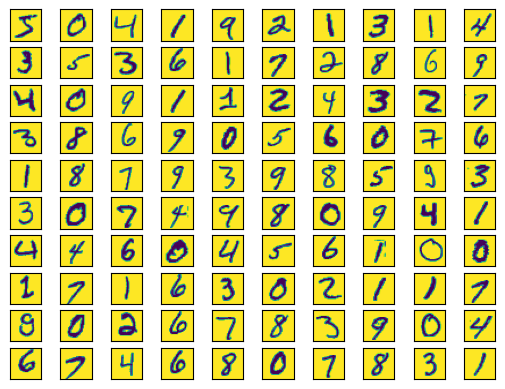

In [51]:
fig, ax = plt.subplots(10, 10)
    
for i in range(10):
    for j in range(10):
        # Plot each image in black and white and hide the axes.
        ax[i][j].imshow(train_images[10 * i + j], cmap='viridis_r')
        ax[i][j].xaxis.set_visible(False)
        ax[i][j].yaxis.set_visible(False)
    
plt.show()

In [54]:
# Load the MNIST test data
    
# test_images = mnist.test_images().tolist()
# test_labels = mnist.test_labels().tolist()
    
# assert shape(test_images) == [10000, 28, 28]
# assert shape(test_labels) == [10000]
    
    
# # Recenter the images

# # Compute the average pixel value
# avg = tensor_sum(train_images) / 60000 / 28 / 28

# # Recenter, rescale, and flatten
# train_images = [[(pixel - avg) / 256 for row in image for pixel in row]
#                 for image in train_images]
# test_images = [[(pixel - avg) / 256 for row in image for pixel in row]
#                for image in test_images]

# assert shape(train_images) == [60000, 784], "images should be flattened"
# assert shape(test_images) == [10000, 784], "images should be flattened"

# # After centering, average pixel should be very close to 0
# assert -0.0001 < tensor_sum(train_images) < 0.0001


# # One-hot encode the test data

# train_labels = [one_hot_encode(label) for label in train_labels]
# test_labels = [one_hot_encode(label) for label in test_labels]

# assert shape(train_labels) == [60000, 10]
# assert shape(test_labels) == [10000, 10]

In [55]:
# # Training loop

# import tqdm

# def loop(model: Layer,
#          images: List[Tensor],
#          labels: List[Tensor],
#          loss: Loss,
#          optimizer: Optimizer = None) -> None:
#     correct = 0         # Track number of correct predictions.
#     total_loss = 0.0    # Track total loss.

#     with tqdm.trange(len(images)) as t:
#         for i in t:
#             predicted = model.forward(images[i])             # Predict.
#             if argmax(predicted) == argmax(labels[i]):       # Check for
#                 correct += 1                                 # correctness.
#             total_loss += loss.loss(predicted, labels[i])    # Compute loss.

#             # If we're training, backpropagate gradient and update weights.
#             if optimizer is not None:
#                 gradient = loss.gradient(predicted, labels[i])
#                 model.backward(gradient)
#                 optimizer.step(model)

#             # And update our metrics in the progress bar.
#             avg_loss = total_loss / (i + 1)
#             acc = correct / (i + 1)
#             t.set_description(f"mnist loss: {avg_loss:.3f} acc: {acc:.3f}")


# # The logistic regression model for MNIST

# random.seed(0)

# # Logistic regression is just a linear layer followed by softmax
# model = Linear(784, 10)
# loss = SoftmaxCrossEntropy()

# # This optimizer seems to work
# optimizer = Momentum(learning_rate=0.01, momentum=0.99)

# # Train on the training data
# loop(model, train_images, train_labels, loss, optimizer)

# # Test on the test data (no optimizer means just evaluate)
# loop(model, test_images, test_labels, loss)


# # A deep neural network for MNIST

# random.seed(0)

# # Name them so we can turn train on and off
# dropout1 = Dropout(0.1)
# dropout2 = Dropout(0.1)

# model = Sequential([
#     Linear(784, 30),  # Hidden layer 1: size 30
#     dropout1,
#     Tanh(),
#     Linear(30, 10),   # Hidden layer 2: size 10
#     dropout2,
#     Tanh(),
#     Linear(10, 10)    # Output layer: size 10
# ])


# # Training the deep model for MNIST

# optimizer = Momentum(learning_rate=0.01, momentum=0.99)
# loss = SoftmaxCrossEntropy()

# # Enable dropout and train (takes > 20 minutes on my laptop!)
# dropout1.train = dropout2.train = True
# loop(model, train_images, train_labels, loss, optimizer)

# # Disable dropout and evaluate
# dropout1.train = dropout2.train = False
# loop(model, test_images, test_labels, loss)

### Saving & Loading Models 

In [56]:
import json

In [58]:
def save_weights(model: Layer, filename: str) -> None:
    weights = list(model.params())
    with open(filename, 'w') as f:
        json.dump(weights, f)

def load_weights(model: Layer, filename: str) -> None:
    with open(filename) as f:
        weights = json.load(f)

    # Check for consistency
    assert all(shape(param) == shape(weight)
               for param, weight in zip(model.params(), weights))

    # Then load using slice assignment:
    for param, weight in zip(model.params(), weights):
        param[:] = weight